In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np 
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import models,datasets
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
from torch.optim import lr_scheduler


In [2]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

device = torch.device("cuda:0" if USE_GPU else "cpu")

using device: cuda


In [3]:
#Hyperparamters
BATCH_SIZE = 32

In [4]:

train_transform = transforms.Compose([
        transforms.Resize(64),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
        transforms.Resize(64),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

In [5]:
train_mnist = torchvision.datasets.FashionMNIST(root = "./", train = True, download = True, transform = train_transform)

In [6]:
print(len(train_mnist)/32)
train_loader = torch.utils.data.DataLoader(train_mnist, batch_size = BATCH_SIZE, shuffle = True)


i,l = next(iter(train_loader))
print(i.shape)

1875.0
torch.Size([32, 1, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


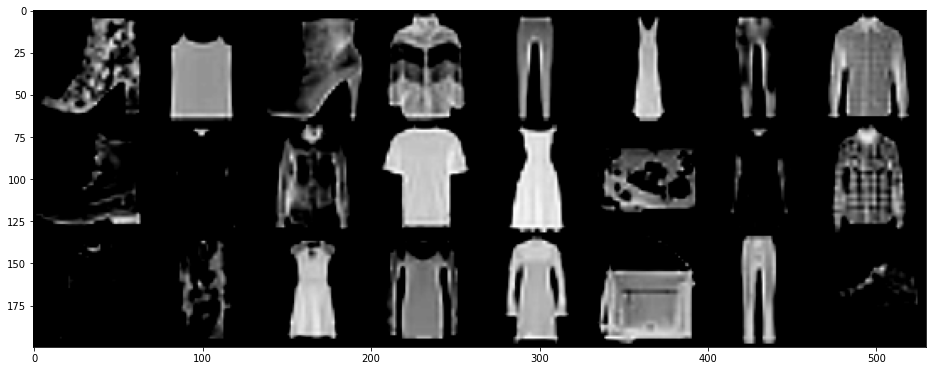

In [7]:
import matplotlib.pyplot as plt
import numpy
samples, labels = iter(train_loader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

In [8]:
class Generator(nn.Module):
    def __init__(self,z_dim,image_dim):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(z_dim,image_dim*8,4,1,0)
        self.deconv1_bn = nn.BatchNorm2d(image_dim*8)
        self.deconv2 = nn.ConvTranspose2d(image_dim*8,image_dim*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(image_dim*4)
        self.deconv3 = nn.ConvTranspose2d(image_dim*4,image_dim*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(image_dim*2)
        self.deconv4 = nn.ConvTranspose2d(image_dim*2,image_dim, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(image_dim)
        self.deconv5 = nn.ConvTranspose2d(image_dim, 1, 4, 2, 1)

    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.leaky_relu(self.deconv1_bn(self.deconv1(input)), 0.2)
        x = F.leaky_relu(self.deconv2_bn(self.deconv2(x)), 0.2)
        x = F.leaky_relu(self.deconv3_bn(self.deconv3(x)), 0.2)
        x = F.leaky_relu(self.deconv4_bn(self.deconv4(x)), 0.2)
        x = torch.tanh(self.deconv5(x))

        return x

class Discriminator(nn.Module):
    def __init__(self,image_dim):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, image_dim, 4, 2, 1)
        self.conv2 = nn.Conv2d(image_dim, image_dim*2, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(image_dim*2)
        self.conv3 = nn.Conv2d(image_dim*2,image_dim*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(image_dim*4)
        self.conv4 = nn.Conv2d(image_dim*4,image_dim*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(image_dim*8)
        self.conv5 = nn.Conv2d(image_dim*8, 1, 4, 1, 0)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))
        return x

In [9]:
#Define loss functions
lr = 1e-5
NUM_EPOCHS = 30
z_dim = 100
image_dim = 64

#d_false = g(noise)
#d_true = next(iter(train_loader))
#gen_loss = np.log(1 - d_false)
#disc_loss = np.log(d_true)+np.log(1-d_false)

d = Discriminator(image_dim)
d = d.to(device)

g = Generator(z_dim,image_dim)
g = g.to(device)
criterion = nn.BCELoss()
gen_opt = optim.Adam(g.parameters(), lr = lr)
disc_opt = optim.Adam(d.parameters(), lr = lr)
real_label = 0
fake_label = 1

torch.Size([64, 64])


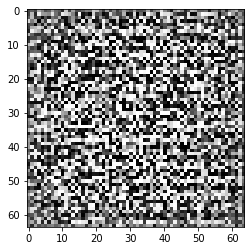

In [10]:
        noise = torch.randn(1,z_dim,1,1).to(device)
        fake = g(noise).detach().cpu()
        img = fake.reshape(64,64)
        img_grid = torchvision.utils.make_grid(fake,normalize = True)
        print(img.shape)
        plt.imshow(img,cmap = "gray")
        plt.show()

EPOCH 1 / 30
Running Generator Loss : 2.0111382365862527
Running Discriminator Loss : 0.3353509645620982
torch.Size([64, 64])


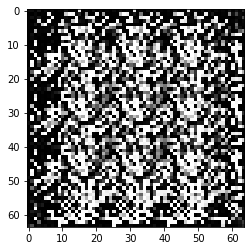

EPOCH 2 / 30
Running Generator Loss : 2.016673523712158
Running Discriminator Loss : 0.33816266333262124
torch.Size([64, 64])


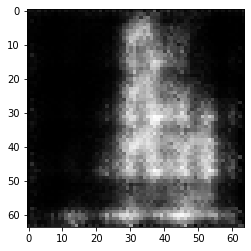

EPOCH 3 / 30
Running Generator Loss : 1.8929490029652913
Running Discriminator Loss : 0.3519520024617513
torch.Size([64, 64])


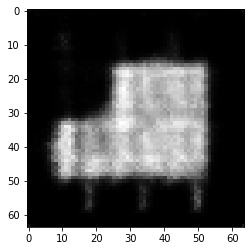

EPOCH 4 / 30
Running Generator Loss : 1.901613172340393
Running Discriminator Loss : 0.35293199682235715
torch.Size([64, 64])


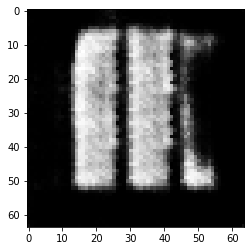

EPOCH 5 / 30
Running Generator Loss : 1.9579372937520345
Running Discriminator Loss : 0.3479099102020264
torch.Size([64, 64])


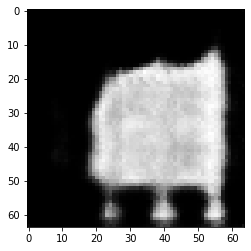

EPOCH 6 / 30
Running Generator Loss : 1.9293579323450725
Running Discriminator Loss : 0.35032623928387957
torch.Size([64, 64])


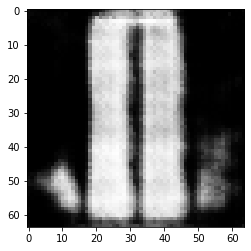

EPOCH 7 / 30
Running Generator Loss : 1.9181851596832276
Running Discriminator Loss : 0.35219556730588275
torch.Size([64, 64])


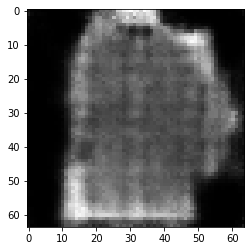

EPOCH 8 / 30
Running Generator Loss : 1.8549117208480834
Running Discriminator Loss : 0.3572030665079753
torch.Size([64, 64])


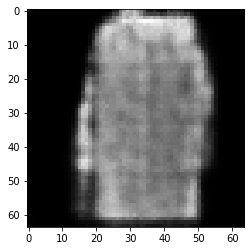

EPOCH 9 / 30
Running Generator Loss : 1.8228681854248048
Running Discriminator Loss : 0.3587579364140828
torch.Size([64, 64])


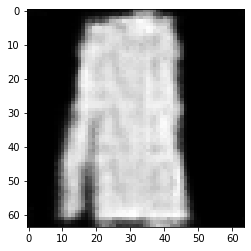

EPOCH 10 / 30
Running Generator Loss : 1.8622204963048299
Running Discriminator Loss : 0.3559095289230347
torch.Size([64, 64])


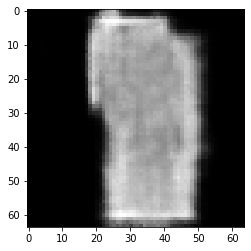

EPOCH 11 / 30
Running Generator Loss : 1.9016573266983032
Running Discriminator Loss : 0.3522746973673503
torch.Size([64, 64])


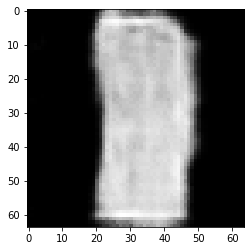

EPOCH 12 / 30
Running Generator Loss : 1.9315761099497477
Running Discriminator Loss : 0.3486756392796834
torch.Size([64, 64])


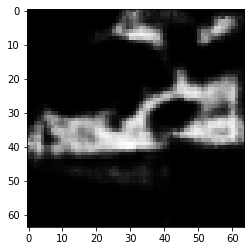

EPOCH 13 / 30
Running Generator Loss : 1.9490721092224121
Running Discriminator Loss : 0.3474296586036682
torch.Size([64, 64])


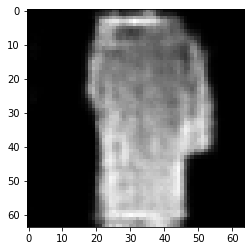

EPOCH 14 / 30
Running Generator Loss : 1.9759166984558105
Running Discriminator Loss : 0.3444667099634806
torch.Size([64, 64])


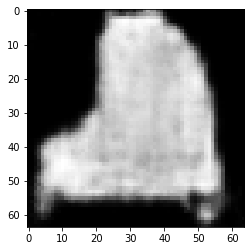

EPOCH 15 / 30
Running Generator Loss : 1.9756322317123414
Running Discriminator Loss : 0.3441985077699026
torch.Size([64, 64])


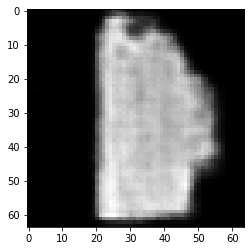

EPOCH 16 / 30
Running Generator Loss : 1.9871581191380818
Running Discriminator Loss : 0.342175851170222
torch.Size([64, 64])


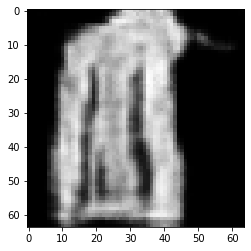

EPOCH 17 / 30
Running Generator Loss : 1.990317949549357
Running Discriminator Loss : 0.3432297828356425
torch.Size([64, 64])


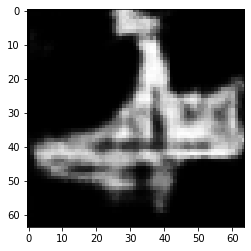

EPOCH 18 / 30
Running Generator Loss : 2.0043043882369993
Running Discriminator Loss : 0.34140076565742494
torch.Size([64, 64])


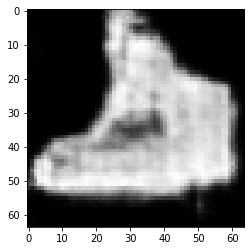

EPOCH 19 / 30
Running Generator Loss : 2.003684902826945
Running Discriminator Loss : 0.34070044445991515
torch.Size([64, 64])


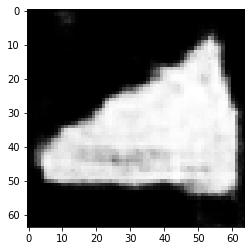

EPOCH 20 / 30
Running Generator Loss : 2.002070847892761
Running Discriminator Loss : 0.3405729209105174
torch.Size([64, 64])


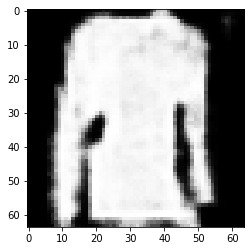

EPOCH 21 / 30
Running Generator Loss : 2.0199054522196453
Running Discriminator Loss : 0.33965466556549073
torch.Size([64, 64])


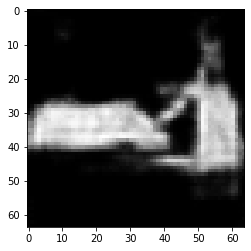

EPOCH 22 / 30
Running Generator Loss : 2.020063698768616
Running Discriminator Loss : 0.33926572335561117
torch.Size([64, 64])


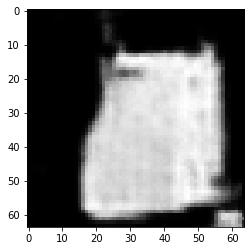

EPOCH 23 / 30
Running Generator Loss : 2.027005299695333
Running Discriminator Loss : 0.3384504494349162
torch.Size([64, 64])


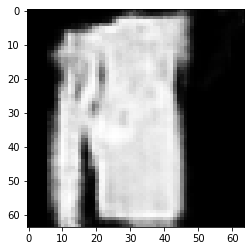

EPOCH 24 / 30
Running Generator Loss : 2.0210532954533895
Running Discriminator Loss : 0.33851860485076907
torch.Size([64, 64])


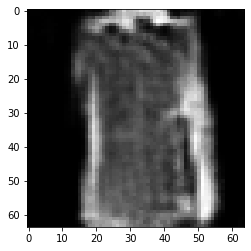

EPOCH 25 / 30
Running Generator Loss : 2.0221728855133057
Running Discriminator Loss : 0.33893145325978596
torch.Size([64, 64])


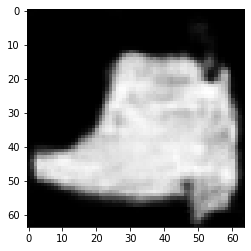

EPOCH 26 / 30
Running Generator Loss : 2.026175597699483
Running Discriminator Loss : 0.3382088435490926
torch.Size([64, 64])


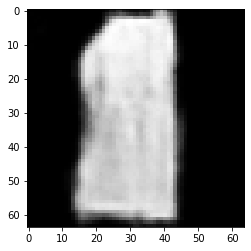

EPOCH 27 / 30
Running Generator Loss : 2.0307476161321003
Running Discriminator Loss : 0.3375863574822744
torch.Size([64, 64])


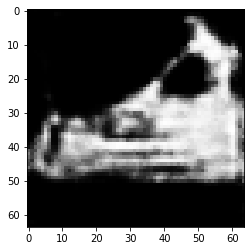

EPOCH 28 / 30
Running Generator Loss : 2.022629767036438
Running Discriminator Loss : 0.338117106850942
torch.Size([64, 64])


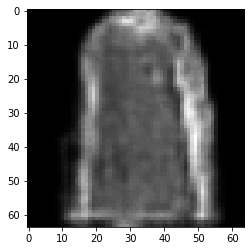

EPOCH 29 / 30
Running Generator Loss : 2.0345639031092326
Running Discriminator Loss : 0.3376556755224864
torch.Size([64, 64])


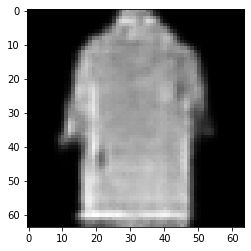

EPOCH 30 / 30
Running Generator Loss : 2.0275664759953815
Running Discriminator Loss : 0.3381474897066752
torch.Size([64, 64])


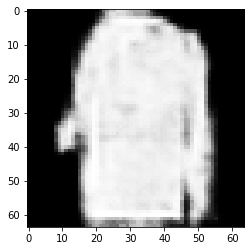

In [11]:
#Train
for epoch in range(NUM_EPOCHS):
    running_g_loss = 0
    running_d_loss =0
    gen_history = []
    disc_history = []
    g.train()
    d.train()
    for idx, (input_image, l) in enumerate(train_loader):
        noise = torch.randn(BATCH_SIZE, z_dim,1,1).to(device)
        input_image = input_image.to(device)
        generated_data = g(noise)
        d_fake = d(generated_data).view(-1)
        d_real = d(input_image).view(-1)
        #forward pass
        
        disc_loss1 = criterion(d_real, torch.ones_like(d_real)*0.1)
        disc_loss2 = criterion(d_fake, torch.ones_like(d_fake)*0.9)
        disc_loss = (disc_loss1+disc_loss2)/2
        #backward
        
        disc_opt.zero_grad() 
        disc_loss.backward(retain_graph = True) #Need to make retain_graph as true if we are reusing computation
        disc_opt.step()
        
        out = d(generated_data).view(-1)
        gen_loss = criterion(out, torch.ones_like(out)*0.1)
        gen_opt.zero_grad()
        gen_loss.backward()
        gen_opt.step()
        
        running_g_loss += gen_loss.item()
        running_d_loss += disc_loss.item()
        gen_history.append(gen_loss.item())
        disc_history.append(disc_loss.item())
    
    print("EPOCH",epoch+1,"/",NUM_EPOCHS)
    print("Running Generator Loss :", running_g_loss/1875)
    print("Running Discriminator Loss :", running_d_loss/1875)
    g.eval()
    noise = torch.randn(1,z_dim,1,1).to(device)
    fake = g(noise).detach().cpu()
    #mg = np.transpose(mid_training,(1,2,0))
    with torch.no_grad():
        img = fake.reshape(64,64)
        img_grid = torchvision.utils.make_grid(fake,normalize = True)
        print(img.shape)
        plt.imshow(img,cmap = "gray")
        plt.show()

   
    
    

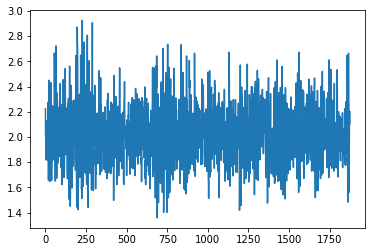

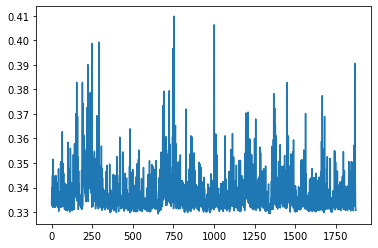

In [13]:
plt.plot(gen_history)
plt.show()
plt.plot(disc_history)
plt.show()